Exampl run file to run Symbolic Regression, using low temperature data ss training data and high temperation data as test data.

The other Symbolic regression result can be generated by using same workflow with different dataset

In [ ]:
#@title Download Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Package

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  julia -e 'println("Success")'
fi

Streaming output truncated to the last 5000 lines.
  ◑ AutoHashEquals
  ◒ Requires
  ◐ CpuId
  ◐ StructTypes
  ◑ UnPack

  ◓ Combinatorics
  ◑ DefineSingletons
  ◓ Compat
  ◓ OrderedCollections
  ◒ AutoHashEquals
  ◐ Requires
  ◓ CpuId
  ◓ StructTypes
  ◒ UnPack
  Progress [>                                        ]  0/110
  ◑ Combinatorics
  ◒ DefineSingletons
  ◑ Compat
  ◑ OrderedCollections
  ◐ AutoHashEquals
  ◓ Requires
  ◑ CpuId
  ◑ StructTypes
  ◐ UnPack
  Progress [>                                        ]  0/110
  ◒ Combinatorics
  ◐ DefineSingletons
  ◒ Compat
  ◒ OrderedCollections
  ◓ AutoHashEquals
  ◑ Requires
  ◒ CpuId
  ◒ StructTypes
  ◓ UnPack
  Progress [>                                        ]  0/110
  ◐ Combinatorics
  ◓ DefineSingletons
  ◐ Compat
  ◐ OrderedCollections
  ◑ AutoHashEquals
  ◒ Requires
  ◐ CpuId
  ◐ StructTypes
  ◑ UnPack
  Progress [>                                        ]  0/110
  ◓ Combinatorics
  ◑ DefineSingletons
  ◓ Compat
  ◓ OrderedCo

In [ ]:
!pip install pysr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 21 kB/s 
     |████████████████████████████████| 68 kB 5.6 MB/s 


In [ ]:
!python -c 'import pysr; pysr.install()'

[ Info: Julia version info
Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      Ubuntu 18.04.6 LTS
  uname: Linux 5.10.133+ #1 SMP Fri Aug 26 08:44:51 UTC 2022 x86_64 x86_64
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz: 
              speed         user         nice          sys         idle          irq
       #1  2199 MHz        440 s          0 s        144 s       1604 s          0 s
       #2  2199 MHz        466 s          0 s        143 s       1586 s          0 s
       #3  2199 MHz        531 s          0 s        132 s       1541 s          0 s
       #4  2199 MHz        567 s          0 s        137 s       1497 s          0 s
       #5  2199 MHz        496 s          0 s        139 s       1571 s          0 s
       #6  2199 MHz        415 s          0 s        132 s       1665 s          0 s
       #7  2199 MHz        539 s          0 s        127 s       1544 s          0 s
       #8  2199 MHz        552 s          0

In [ ]:
!pip install -U jaxlib
!pip install -U jax
!pip install -q --upgrade git+https://www.github.com/google/jax-md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71.2 MB 107.4 MB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.22+cuda11.cudnn805
    Uninstalling jaxlib-0.3.22+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.22+cuda11.cudnn805
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
  Created wheel for jax: filename=jax-0.3.25-py3-none-any.whl size=1308509 sha256=aa0d3dbaca1330a9931bdebd3888f03657d10623b6647895062132d33fb6c3b6
  Stored in directory: /root/.cache/pip/wheels/a5/79/44/dbae745c48940291d6d4d157f7faa6f0b27f198781073d8c78
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.23
    Uninstalling jax-0.3.23:
      Successfully uninstalled jax-0.3.23
     |████████████████████████████████| 352 kB 4.1 MB/s 
     

# Data Process

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
from jax import vmap, jit, lax, grad, random
from jax_md import energy,  simulate, space, quantity

In [ ]:
import pickle
# Note: Replace the file paths with those relevant to your project.
with open('/content/drive/My Drive/GNNWithSymbolicRegression/data/GNN_Data/GNN_Record_lowTemp.pickle', 'rb') as f:
  message = pickle.load(f)

with open('/content/drive/My Drive/GNNWithSymbolicRegression/data/GNN_Data/GNN_Record_highTemp.pickle', 'rb') as f:
  test_message = pickle.load(f)

In [ ]:
message

,dr,e0
0,0.000000,0.214995
1,1.513041,-0.323482
2,3.480156,-0.004608
3,4.188698,-0.004608
4,3.648031,-0.004608
...,...,...
147451,1.568441,-0.271556
147452,5.791136,0.000000
147453,4.267128,-0.004608
147454,6.656171,0.000000


In [ ]:
messagelast = message

box_size_train = 1.3750448600704519e+01 - 4.1751703855234110e+00
r_cutoff = 3

messagelast.drop(messagelast.index[messagelast['dr'] > r_cutoff], inplace=True)
messagelast.drop(messagelast.index[messagelast['dr'] == 0], inplace=True)

test_message.drop(test_message.index[test_message['dr'] > r_cutoff], inplace=True)
test_message.drop(test_message.index[test_message['dr'] == 0], inplace=True)

In [ ]:
X = np.array(messagelast['dr'])
Y = np.array(messagelast['e0'])
x = np.reshape(X,-1)
y = np.reshape(Y,-1)

x = x.reshape(-1,1)

Xtest = np.array(test_message['dr'])
Ytest = np.array(test_message['e0'])
xtest = np.reshape(Xtest,-1)
ytest = np.reshape(Ytest,-1)

xtest = xtest.reshape(-1,1)

Compare recorded GNN edge feature with true Lennard-jones value

In [ ]:
result = energy.lennard_jones(X)

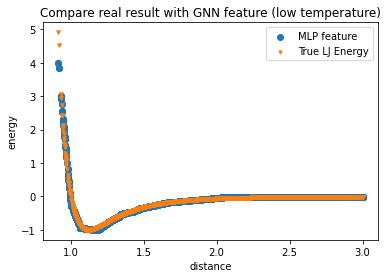

In [ ]:
plt.title('Compare real result with GNN feature (low temperature)')
plt.xlabel('distance')
plt.ylabel('energy')
plt.scatter(x,y, label = 'MLP feature')
plt.scatter(x,result,  marker = 'v', s = 10, label = 'True LJ Energy')
plt.legend()

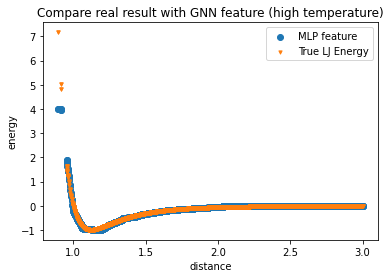

In [ ]:
test_result = energy.lennard_jones(Xtest)
plt.title('Compare real result with GNN feature (high temperature)')
plt.xlabel('distance')
plt.ylabel('energy')
plt.scatter(xtest,ytest, label = 'MLP feature')
plt.scatter(xtest,test_result,  marker = 'v', s = 10, label = 'True LJ Energy')
plt.legend()

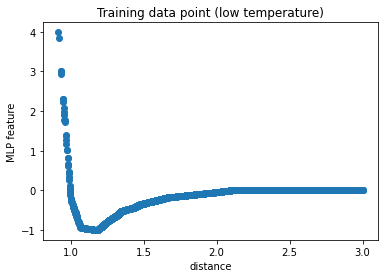

In [ ]:
xtrain, xtest_nouse, ytrain, ytest_nouse = train_test_split(x, y, test_size=0.3, random_state=42)
xtrain = xtrain[0:8000]
ytrain = ytrain[0:8000]

plt.title('Training data point (low temperature)')
plt.xlabel('distance')
plt.ylabel('MLP feature')
plt.scatter(xtrain,ytrain)

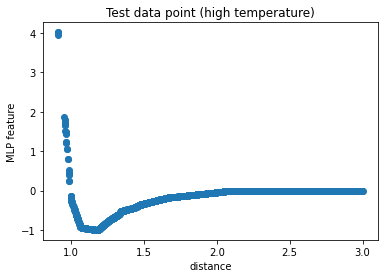

In [ ]:
xtrain_nouse, xtest, ytrain_nouse, ytest = train_test_split(xtest, ytest, test_size=0.3, random_state=42)

plt.title('Test data point (high temperature)')
plt.xlabel('distance')
plt.ylabel('MLP feature')
plt.scatter(xtest,ytest)

# Run symbolic regression

In [ ]:
from pysr import PySRRegressor
model = PySRRegressor(
    model_selection="best",  # Result is mix of simplicity+accuracy
    niterations=80,
    maxsize=65,
    #maxdepth=12,
    binary_operators=["+", "*", "-"],
    #loss="L2DistLoss()", #MSE
    loss="myloss(x, y, w) = w * abs(x - y)^2",
    unary_operators=[
        #"exp",
        "inv(x)=1/x",
        "pow2(x)=x^2",
        "pow3(x)=x^3",
        "pow4(x)=x^4",
    # ^ Custom operator (julia syntax)
    ],
    #parsimony = 0.005,
    populations=60,
    procs=2,
    population_size=65,
    extra_sympy_mappings={"inv": lambda x: 1 / x, "pow2": lambda x: x ** 2, "pow3": lambda x: x ** 3, "pow4": lambda x: x ** 4},
    #denoise=True
    equation_file="/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_original.csv"
)

In [ ]:
weight = 1/(xtrain * xtrain)
weight = np.reshape(weight,-1)
weight.shape

(8000,)

In [ ]:
model.fit(xtrain, ytrain, weights=weight, variable_names=['x']) #lower r, highter weight, higher r, lower weight

/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1188: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory. You should consider turning `use_frequency` to False, and perhaps use `warmup_maxsize_by`.
  "Note: Using a large maxsize for the equation search will be "
/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1251: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                        -0.23501049   
	1         9.471329e-02                               (0.3355407 - inv(x))   
	2         3.151402e-02                     (-0.9510156 + (x * 0.3745666))   
	3         1.527206e-02                      (pow4(inv(pow4(x))) - inv(x))   
	4         1.093474e+00                (pow4(inv(pow4(x))) - inv(pow3(x)))   
	5         2.286342e-01          (pow3(pow3(pow2(inv(x)))) - inv(pow3(x)))   
	6         1.750103e+00  ((pow4(pow4(inv(x))) - inv(pow4(x))) * 1.9393976)   
	7         1.174567e+00  ((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * 4...   
	8         1.605968e-02  ((pow4(inv(pow3(x) + 0.0016597142)) - inv(pow3...   
	9         6.463892e-02  ((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * (...   
	10        9.029419e-02  ((((pow4(pow3(inv(x))) * x) - inv(pow2(pow3(x)...   
	11        9.088501e-03  ((pow4(pow

In [ ]:
model.set_params(extra_sympy_mappings={"inv": lambda x: 1/x, "pow2": lambda x: x ** 2, "pow3": lambda x: x ** 3, "pow4": lambda x: x ** 4})
model.sympy()

-1/(0.08568306645889*(-x**4 + 1/(x + (x**4 - x)**3) - 1/x**48)**2 + 0.80318775250884) + x**(-16)

In [ ]:
model.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.189638,0.000000e+00,-0.23501049,-0.235010490000000,PySRFunction(X=>-0.235010490000000)
1,4,0.142733,9.471329e-02,(0.3355407 - inv(x)),0.3355407 - 1/x,PySRFunction(X=>0.3355407 - 1/x)
2,5,0.138305,3.151402e-02,(-0.9510156 + (x * 0.3745666)),0.3745666*x - 0.9510156,PySRFunction(X=>0.3745666*x - 0.9510156)
3,7,0.134144,1.527206e-02,(pow4(inv(pow4(x))) - inv(x)),-1/x + x**(-16),PySRFunction(X=>-1/x + x**(-16))
4,8,0.044945,1.093474e+00,(pow4(inv(pow4(x))) - inv(pow3(x))),-1/x**3 + x**(-16),PySRFunction(X=>-1/x**3 + x**(-16))
5,9,0.035759,2.286342e-01,(pow3(pow3(pow2(inv(x)))) - inv(pow3(x))),-1/x**3 + x**(-18),PySRFunction(X=>-1/x**3 + x**(-18))
6,10,0.006213,1.750103e+00,((pow4(pow4(inv(x))) - inv(pow4(x))) * 1.9393976),-1.9393976/x**4 + 1.9393976/x**16,PySRFunction(X=>-1.9393976/x**4 + 1.9393976/x*...
7,11,0.001920,1.174567e+00,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * 4...,-4.030358/x**6 + 4.030358/x**12,PySRFunction(X=>-4.030358/x**6 + 4.030358/x**12)
8,13,0.001859,1.605968e-02,((pow4(inv(pow3(x) + 0.0016597142)) - inv(pow3...,4.045447/(x**3 + 0.0016597142)**4 - 4.045447/x**6,PySRFunction(X=>4.045447/(x**3 + 0.0016597142)...
9,14,0.001743,6.463892e-02,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * (...,(4.930317 - 1/x)*(-1/x**6 + x**(-12)),PySRFunction(X=>(4.930317 - 1/x)*(-1/x**6 + x*...


In [ ]:
xtest = xtest[0:2000]
ytest = ytest[0:2000]

y_gp1 = model.predict(xtest,5)
print("MSE on validation set:", np.power(y_gp1 - ytest, 2).mean())

ytrain_gp = model.predict(xtrain,5)
print("MSE on training set:", np.power(ytrain_gp - ytrain, 2).mean())

MSE on validation set: 0.01476867045524837
MSE on training set: 0.013721798438730885


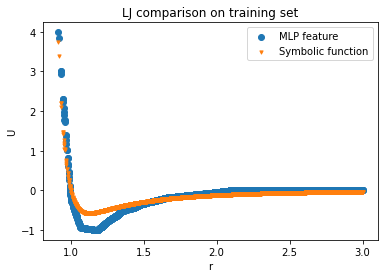

In [ ]:
ytrain_true = energy.lennard_jones(xtrain)
plt.title('LJ comparison on training set')
plt.xlabel('r')
plt.ylabel('U')
plt.scatter(xtrain, ytrain, label = 'MLP feature')
#plt.scatter(xtrain, ytrain_true, label = 'True LJ function')
plt.scatter(xtrain, ytrain_gp, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()

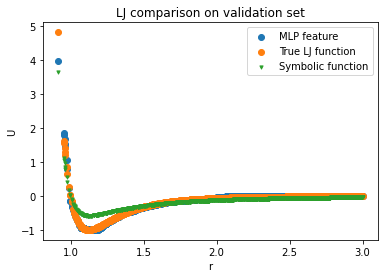

In [ ]:
ytest_true = energy.lennard_jones(xtest)
plt.title('LJ comparison on validation set')
plt.xlabel('r')
plt.ylabel('U')
plt.scatter(xtest, ytest, label = 'MLP feature')
plt.scatter(xtest, ytest_true, label = 'True LJ function')
plt.scatter(xtest, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()

# Test Generated Equations on validation set

In [ ]:
from sympy import *
from sympy.utilities.misc import func_name
import pandas as pd
import numpy as np
from sympy.abc import x
from sympy import lambdify

#Define Utility Functions
# These functions are used to evaluate all generated functions

def get_complexity(sympy_expr, extra_complexity_expo=0):
    """
    Method that computes complexity. Which is just the length of operations + variables + floats/ints.
    This is same as defined in PySR although ignore unary operations because of sympy mapping.
    Complexity can be higher if many unary operations are defined.
    :param extra_complexity_expo: complexity of custom operators.
    :param sympy_expr: A sympy expression.
    :return: An integer quantifying the complexity of the given sympy expression.
    """
    operator_count = [func_name(i) for i in sympy_expr.atoms(Basic)]
    return len(operator_count) + extra_complexity_expo


def get_score(losses, complexities):
    """
    Computes scores
    :param losses: array of losses
    :param complexities: array of new complexities
    :return: score
    """
    # This is same as defined in PySR
    new_score = []
    for i in range(len(losses)):
        if i == 0:
            new_score.append(0)
        else:
            if (complexities[i] - complexities[i - 1]) == 0:
                new_score.append(np.inf)
            else:
                new_score.append(-np.log(losses[i] / losses[i - 1]) / (complexities[i] - complexities[i - 1]))
    return new_score

In [ ]:
def complexity_sympy_simplify(xtest, ytest, final_model=None, rounding_tol=1e-6, read_from_csv=False, in_csv_name="HOF.csv",
                              custom_complexity_expo=False, out_csv_name="HOF_simplified.csv",
                              extra_sympy_mappings=None):
    """
    Method to compute complexity and avoid repeated expression. Needs sympy mapping to work.
    :param extra_sympy_mappings: Sympy mappings same as the one used in PySR.
    :param custom_complexity_expo: If one uses custom_complexity.
    :param in_csv_name: Input .csv file name. Ideally after the symbolic regression is converged.
    :param out_csv_name: Output .csv file name.
    :param final_model: PySR regressor. Ideally a model after the symbolic regression is converged.
    :param rounding_tol: Rounding tolerance for floating point digits.
    :param read_from_csv: If one reads file from PySR hall of fame in .csv format.
    :return: dataframe with new and old complexity with simplified equations.
    """
    if read_from_csv:
        eqs_df = pd.read_csv(in_csv_name, delimiter = ",")
        eqs_df.columns = ['complexity', 'loss', 'equation']
        eqs_df['score'] = get_score(eqs_df['loss'], eqs_df['complexity'])
        n_eqs = np.arange(0, eqs_df['complexity'][:].shape[0], 1, dtype=np.int64)
        n_eqs_sympy = Array(sympify(eqs_df['equation'], locals=extra_sympy_mappings))
    else:
        eqs_df = final_model.equation_file_contents_[0]
        n_eqs = np.arange(0, eqs_df['complexity'][:].shape[0], 1, dtype=np.int64)
        n_eqs_sympy = Array(final_model.sympy(n_eqs))
    n_eqs_sympy_simplify = simplify(n_eqs_sympy)
    n_eqs_sympy_simplify_round = []
    new_complexity = []
    test_MSE_loss = []


    for i in range(len(n_eqs)):
        rounding_eqs = n_eqs_sympy_simplify[i]
        number_of_exponents = 0
        extra_complexity_count = 0
        for j in preorder_traversal(n_eqs_sympy_simplify[i]):
            if custom_complexity_expo:
                if j.is_Pow:
                    base, expo = j.args
                    extra_complexity_count += 1 * abs(expo)
                    number_of_exponents += 1

            if isinstance(j, Float):
                if (j - round(j)) ** 2 < rounding_tol:
                    rounding_eqs = rounding_eqs.subs(j, round(j))
        # We subtract because we count it in the get_score
        extra_complexity_N = np.sum(extra_complexity_count) - np.sum(number_of_exponents)
        print("Extra complexity", extra_complexity_N)

        #test on validation set
        if read_from_csv:
          f = lambdify(x, n_eqs_sympy[i], "numpy")
          y_gp1 = f(xtest)
          if not np.isscalar(y_gp1):
            y_gp1 = y_gp1.reshape(-1)
        else:
          y_gp1 = final_model.predict(xtest,i)
          #y_gp1 = y_gp1.astype('float32')
        test_MSE_loss.append(np.power(y_gp1 - ytest, 2).mean())
        n_eqs_sympy_simplify_round.append(rounding_eqs), new_complexity.append(get_complexity(rounding_eqs,
                                                                                              extra_complexity_expo=extra_complexity_N))

    dictionary = {'loss': eqs_df['loss'],'Validation_loss':test_MSE_loss, 'score': eqs_df['score'],
                  'Validation_score': get_score(test_MSE_loss, eqs_df['complexity']),
                  'Old_Complexity': eqs_df['complexity'], 'New_Complexity': new_complexity,
                  'Old_equation': eqs_df['equation'], 'New_equation': n_eqs_sympy_simplify_round}

    df = pd.DataFrame(data=dictionary)
    df.to_csv(out_csv_name, sep='|', index=False, header=True)
    return df

In [ ]:
ytest.size

5946

In [ ]:
#Recompute complexity and simplify the equation form
b = complexity_sympy_simplify(xtest[0:800],ytest[0:800], final_model=None, rounding_tol=1e-6, read_from_csv=True, in_csv_name= "/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_original.csv",
                               custom_complexity_expo=False, out_csv_name="/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_simplify.csv",
                               extra_sympy_mappings={"x0":x, "inv": lambda x: 1 / x, "pow2": lambda x: x ** 2, "pow3": lambda x: x ** 3, "pow4": lambda x: x ** 4})

Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0
Extra complexity 0


In [ ]:
b

,loss,Validation_loss,score,Validation_score,Old_Complexity,New_Complexity,Old_equation,New_equation
0,0.189638,0.087351,0.000000e+00,0.000000,1,1,-0.23501049,-0.235010490000000
1,0.142733,0.037488,9.471329e-02,0.281969,4,6,(0.3355407 - inv(x)),0.3355407 - 1/x
2,0.138305,0.041532,3.151402e-02,-0.102428,5,5,(-0.9510156 + (x * 0.3745666)),0.3745666*x - 0.9510156
3,0.134144,0.145047,1.527206e-02,-0.625302,7,10,(pow4(inv(pow4(x))) - inv(x)),(1 - x**15)/x**16
4,0.044945,0.017752,1.093474e+00,2.100557,8,10,(pow4(inv(pow4(x))) - inv(pow3(x))),(1 - x**13)/x**16
5,0.035759,0.015367,2.286342e-01,0.144296,9,10,(pow3(pow3(pow2(inv(x)))) - inv(pow3(x))),(1 - x**15)/x**18
6,0.006213,0.003170,1.750103e+00,1.578411,10,11,((pow4(pow4(inv(x))) - inv(pow4(x))) * 1.9393976),1.9393976*(1 - x**12)/x**16
7,0.001920,0.000543,1.174567e+00,1.765022,11,11,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * 4...,4.030358*(1 - x**6)/x**12
8,0.001859,0.000600,1.605968e-02,-0.050493,13,14,((pow4(inv(pow3(x) + 0.0016597142)) - inv(pow3...,4.045447/(x**3 + 0.0016597142)**4 - 4.045447/x**6
9,0.001743,0.000689,6.463892e-02,-0.137812,14,11,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * (...,-(4.930317*x - 1)*(x**6 - 1)/x**13


# Re-sort Generated Quations to Select the Best One

1. calculate score based on validation loss
2. best: based on validation loss
3. function with same complexity: only leave the lowest loss -> select

In [ ]:
#Define Utility Functions
#These functions are used to sort all equation and select the best equation
def function_resort(in_csv_name="HOF.csv",out_csv_name="HOF_simplified.csv"):
  b = pd.read_csv(in_csv_name, delimiter = "|")
  df_1 = pd.DataFrame(data=b)
  df_1 = df_1.drop(["Old_equation"], axis=1)
  df_1.insert(0,"old_index",df_1.index)
  sorted = df_1.sort_values(['New_Complexity','Validation_loss'], ignore_index = True)
  sorted = sorted.drop_duplicates(['New_Complexity'],ignore_index=True)
  sorted['new_score'] = get_score(sorted['loss'], sorted['New_Complexity'])
  sorted['Validation_new_score'] = get_score(sorted['Validation_loss'], sorted['New_Complexity'])
  df = pd.DataFrame(data=sorted)
  df.to_csv(out_csv_name, sep='|', index=False, header=True)
  return df

def select_function(in_csv_name, model_selection:str, best_param = 1.5):
  equations= pd.read_csv(in_csv_name, delimiter = "|")
  equations = equations.query(f'new_score != inf')
  if model_selection == "accuracy":
        chosen_idx = equations['Validation_loss'].idxmin()
  elif model_selection == "best":
        threshold = best_param * equations['Validation_loss'].min()
        filtered_equations = equations.query(f'Validation_loss <= {threshold}')
        chosen_idx = filtered_equations["new_score"].idxmax()

  elif model_selection == "score":
        chosen_idx = equations["Validation_new_score"].idxmax()
  else:
        raise NotImplementedError(
            f"{model_selection} is not a valid model selection strategy."
        )
  return chosen_idx

In [ ]:
#The new list of equations sorted based on new complexity and loss
df = function_resort(in_csv_name = "/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_simplify.csv",
                     out_csv_name = "/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_simplify_re_sort.csv")

In [ ]:
df

,loss,Validation_loss,score,Validation_score,Old_Complexity,New_Complexity,Old_equation,New_equation
0,0.189638,0.087351,0.000000e+00,0.000000,1,1,-0.23501049,-0.235010490000000
1,0.142733,0.037488,9.471329e-02,0.281969,4,6,(0.3355407 - inv(x)),0.3355407 - 1/x
2,0.138305,0.041532,3.151402e-02,-0.102428,5,5,(-0.9510156 + (x * 0.3745666)),0.3745666*x - 0.9510156
3,0.134144,0.145047,1.527206e-02,-0.625302,7,10,(pow4(inv(pow4(x))) - inv(x)),(1 - x**15)/x**16
4,0.044945,0.017752,1.093474e+00,2.100557,8,10,(pow4(inv(pow4(x))) - inv(pow3(x))),(1 - x**13)/x**16
5,0.035759,0.015367,2.286342e-01,0.144296,9,10,(pow3(pow3(pow2(inv(x)))) - inv(pow3(x))),(1 - x**15)/x**18
6,0.006213,0.003170,1.750103e+00,1.578411,10,11,((pow4(pow4(inv(x))) - inv(pow4(x))) * 1.9393976),1.9393976*(1 - x**12)/x**16
7,0.001920,0.000543,1.174567e+00,1.765022,11,11,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * 4...,4.030358*(1 - x**6)/x**12
8,0.001859,0.000600,1.605968e-02,-0.050493,13,14,((pow4(inv(pow3(x) + 0.0016597142)) - inv(pow3...,4.045447/(x**3 + 0.0016597142)**4 - 4.045447/x**6
9,0.001743,0.000689,6.463892e-02,-0.137812,14,11,((pow4(pow3(inv(x))) - inv(pow2(pow3(x)))) * (...,-(4.930317*x - 1)*(x**6 - 1)/x**13


In [ ]:
#the index of select function
idx = select_function(in_csv_name = "/content/drive/My Drive/GNNWithSymbolicRegression/data/SR_Result/SR_function_train_lowtemp_simplify_re_sort.csv", model_selection = 'score')

In [ ]:
idx

4

In [ ]:
df['loss'][idx]

0.0019196419

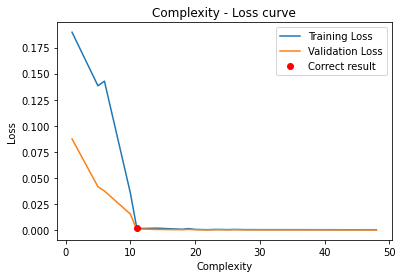

In [ ]:
plt.title('Complexity - Loss curve')
plt.xlabel('Complexity')
plt.ylabel('Loss')
plt.plot(df['New_Complexity'],df['loss'], label = 'Training Loss')
plt.plot(df['New_Complexity'],df['Validation_loss'], label = 'Validation Loss')
plt.plot(df['New_Complexity'][idx],df['loss'][idx],'or',label = 'Correct result')
plt.legend()

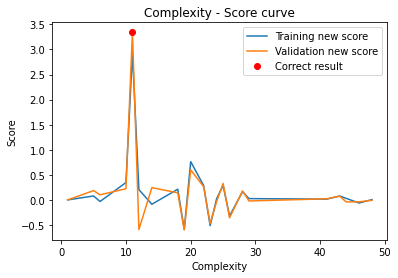

In [ ]:
plt.title('Complexity - Score curve')
plt.xlabel('Complexity')
plt.ylabel('Score')
plt.plot(df['New_Complexity'],df['new_score'], label = 'Training new score')
plt.plot(df['New_Complexity'],df['Validation_new_score'], label = 'Validation new score')
plt.plot(df['New_Complexity'][idx],df['Validation_new_score'][idx],'or',label = 'Correct result')
plt.legend()